# Scale Taxi

In [9]:
from pandas import read_csv, concat, DataFrame, read_feather
import os, csv

In [10]:
df = read_csv('train.csv', nrows=1_000_000)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [11]:
%%time
local_path = os.getcwd()
source = 'train1.csv'
SEP=','
running_mean = list()
running_std = list()
with open(local_path+'/'+source, 'r') as R:
    iterator = csv.DictReader(R, delimiter=SEP)
    x = 0.0
    x_squared = 0.0
    for n, row in enumerate(iterator):
        fare_amount = float(row['fare_amount'])
        if n == 0:
            max_x, min_x = fare_amount, fare_amount
        else:
            max_x, min_x = max(fare_amount, max_x),min(fare_amount, min_x)
        x += fare_amount
        x_squared += fare_amount**2
        running_mean.append(x / (n+1))
        running_std.append(((x_squared - (x**2)/(n+1))/(n+1))**0.5)
        # DATA PROCESSING placeholder
        # MACHINE LEARNING placeholder
        pass
    print ('Total rows: %i' % (n+1))
    print ('Feature \'fare_amount\': mean=%0.3f, max=%0.3f, min=%0.3f,sd=%0.3f' \
           % (running_mean[-1], max_x, min_x, running_std[-1]))

Total rows: 2000000
Feature 'fare_amount': mean=11.335, max=900.000, min=-76.000,sd=9.800
Wall time: 20.6 s


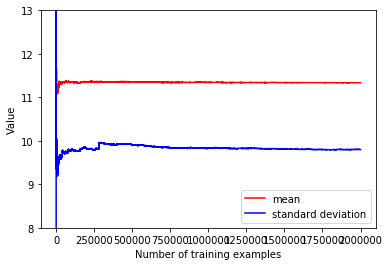

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(running_mean,'r-', label='mean')
plt.plot(running_std,'b-', label='standard deviation')
plt.ylim(8,13)
plt.xlabel('Number of training examples')
plt.ylabel('Value')
plt.legend(loc='lower right', numpoints= 1)
plt.show()

# szelee code1

In [ ]:
from pandas import read_csv, concat, DataFrame, read_feather
import os, csv

In [2]:
%%time
df = read_csv('train.csv', nrows=10_000_000)
df.shape

CPU times: user 15.9 s, sys: 2.72 s, total: 18.7 s
Wall time: 19.8 s


In [3]:
TRAIN_PATH = 'train3M.csv' # 2M

In [4]:
%%time
# Assume we only know that the csv file is somehow large, but not the exact size
# we want to know the exact number of rows

with open(TRAIN_PATH) as file:
    n_rows = len(file.readlines())-1

print (f'Exact number of rows: {n_rows}')

Exact number of rows: 3000000
CPU times: user 981 ms, sys: 704 ms, total: 1.68 s
Wall time: 1.8 s


In [5]:
# Peep at the training file header
df_tmp = read_csv(TRAIN_PATH, nrows=5)
df_tmp.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-02-23 22:09:16.0000002,7.0,2015-02-23 22:09:16 UTC,-73.944046,40.795403,-73.947319,40.777756,1
1,2010-05-27 21:29:00.000000145,21.7,2010-05-27 21:29:00 UTC,-73.974483,40.750332,-73.942640,40.843090,5
2,2012-08-26 02:10:00.00000039,7.7,2012-08-26 02:10:00 UTC,-73.988013,40.718607,-73.973652,40.743648,1
3,2013-08-04 07:31:24.0000002,3.0,2013-08-04 07:31:24 UTC,-73.971072,40.761355,-73.974647,40.758150,1
4,2013-10-22 21:06:24.0000005,10.5,2013-10-22 21:06:24 UTC,-73.987457,40.780368,-73.978360,40.755947,1


In [6]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
key                  5 non-null object
fare_amount          5 non-null float64
pickup_datetime      5 non-null object
pickup_longitude     5 non-null float64
pickup_latitude      5 non-null float64
dropoff_longitude    5 non-null float64
dropoff_latitude     5 non-null float64
passenger_count      5 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 400.0+ bytes


We might not need float64 (16 decimal places) for the longitude and latitude values. float32 (7 decimal places) might be just enough.

See https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude/8674#8674

In [7]:
# Set columns to most suitable type to optimize for memory usage
types = {'fare_amount': 'float32',
         'pickup_longitude': 'float32',
         'pickup_latitude': 'float32',
         'dropoff_longitude': 'float32',
         'dropoff_latitude': 'float32',
         'passenger_count': 'uint8'}

# Columns to keep (basically discarding the 'key' column) - thanks to the suggestion by mhviraf
cols = ['fare_amount', 'pickup_datetime',
        'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude',
        'passenger_count']

In [8]:
df_list = [] # list to hold the batch dataframe
chunksize = 1_000_000 # 1 million rows at one go. Or try 10 million
total_chunk = n_rows // chunksize
print(f'Chunk size: {chunksize:,}\nTotal chunks required: {total_chunk}')
i=0

Chunk size: 1,000,000
Total chunks required: 3


In [9]:
%%time

for df_chunk in read_csv(TRAIN_PATH, parse_dates=["pickup_datetime"], usecols=cols,
                         infer_datetime_format=True, dtype=types, chunksize=chunksize):
    
    i = i+1
    # Each chunk is a corresponding dataframe
    print(f'DataFrame Chunk {i}/{total_chunk}')
    
    # Can process each chunk of dataframe here
    # feature_engineer(), remove_outliers(), fit(), predict()
    
    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk) 

DataFrame Chunk 1/3
DataFrame Chunk 2/3
DataFrame Chunk 3/3
CPU times: user 23.1 s, sys: 627 ms, total: 23.8 s
Wall time: 22.5 s


In [10]:
# Merge all dataframes into one dataframe
train_df = concat(df_list)

In [11]:
del df_list

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns](1), float32(5), uint8(1)
memory usage: 83.0 MB


In [13]:
%%time
os.makedirs('tmp', exist_ok=True)
# Save into feather format, about 1.5Gb. 
train_df.to_feather('tmp/train3M.feather')

CPU times: user 142 ms, sys: 141 ms, total: 284 ms
Wall time: 1.97 s


In [39]:
%%time
# load the same dataframe next time directly, without reading the csv file again!
train_df2 = read_feather('tmp/train1M.feather')

CPU times: user 20.2 ms, sys: 15.7 ms, total: 35.9 ms
Wall time: 33.9 ms


In [16]:
# print the dataframe info to verify we have indeed loaded the saved dataframe of 55 million rows
train_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
fare_amount          100000 non-null float32
pickup_datetime      100000 non-null datetime64[ns]
pickup_longitude     100000 non-null float32
pickup_latitude      100000 non-null float32
dropoff_longitude    100000 non-null float32
dropoff_latitude     100000 non-null float32
passenger_count      100000 non-null uint8
dtypes: datetime64[ns](1), float32(5), uint8(1)
memory usage: 2.8 MB


# szelee code2

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
import numpy as np 
#import pandas as pd 
import matplotlib.pyplot as plt
import os

In [ ]:
# Set columns to most suitable type to optimize for memory usage, 
# We can also drop passenger_count since it's not used in this kernel, but I just keep it since it uses only uint8
types = {'fare_amount': 'float32',
         'passenger_count': 'uint8'}

# Columns to load for training data
cols_train = ['fare_amount', 'pickup_datetime', 'passenger_count']

# Columns to load for test data
cols_test = ['pickup_datetime', 'passenger_count']

In [ ]:
df_list = [] # list to hold the batch dataframe
chunksize = 1_000_000 # 1 million rows at one go. 

In [ ]:
%%time
i=0
for df_chunk in read_csv('train1.csv', parse_dates=["pickup_datetime"], usecols=cols_train,
                         infer_datetime_format=True, dtype=types, chunksize=chunksize):
    
    i = i+1
    print(f'DataFrame Chunk {i}')
    df_list.append(df_chunk) 

In [ ]:
# Merge all dataframes into one dataframe
train_df = concat(df_list)

In [ ]:
del df_list

In [ ]:
train_df.info()

In [ ]:
%%time
os.makedirs('tmp', exist_ok=True)
train_df.to_feather('tmp/taxi-train-no-gps.feather')

In [ ]:
test_df = read_csv('test.csv', parse_dates=["pickup_datetime"], usecols=cols_test,
                         infer_datetime_format=True, dtype=types)

In [ ]:
test_df.to_feather('tmp/taxi-test-no-gps.feather')

## Load data feather format

In [13]:
from pandas import read_feather
import matplotlib.pyplot as plt
import os

In [14]:
%%time
train_df = read_feather('tmp/taxi-train-no-gps.feather')

Wall time: 62.9 ms


In [15]:
train_df.head()

,fare_amount,pickup_datetime,passenger_count
0,34.669998,2009-10-09 18:05:00,1
1,4.000000,2014-03-25 18:08:00,5
2,3.300000,2009-02-21 01:04:00,1
3,7.300000,2011-10-17 20:28:11,1
4,7.000000,2014-06-04 09:06:32,1


In [16]:
%%time
test_df = read_feather('tmp/taxi-test-no-gps.feather')

Wall time: 3.49 ms


In [17]:
test_df.head()

,pickup_datetime,passenger_count
0,2015-01-27 13:08:24,1
1,2015-01-27 13:08:24,1
2,2011-10-08 11:53:44,1
3,2012-12-01 21:12:12,1
4,2012-12-01 21:12:12,1


## Group and aggregate by year-month

In [18]:
# Group all training data rides by month+year combination and aggregate them by count, mean, median, min and max
fare_grouped_df = train_df.fare_amount.groupby([train_df.pickup_datetime.dt.year,
                                                train_df.pickup_datetime.dt.month])

fare_count_df = fare_grouped_df.count()
fare_mean_df = fare_grouped_df.mean()
fare_median_df = fare_grouped_df.median()
fare_min_df = fare_grouped_df.min()
fare_max_df = fare_grouped_df.max()

In [19]:
# for drawing barchart, so we don't have to retype the following everytime
def draw_barchart(df, title):
    fig = plt.figure(figsize=(20, 4))
    ax = fig.add_subplot(111)
    df.plot(kind='bar')
    ax.set_xlabel("(Year,Month)")
    plt.title(title)
    plt.show()

## Monthly ride count

In [20]:
fare_count_df.describe()

count       78.000000
mean     25641.025641
std       1776.663917
min      20105.000000
25%      24562.500000
50%      25797.000000
75%      26890.500000
max      29266.000000
Name: fare_amount, dtype: float64

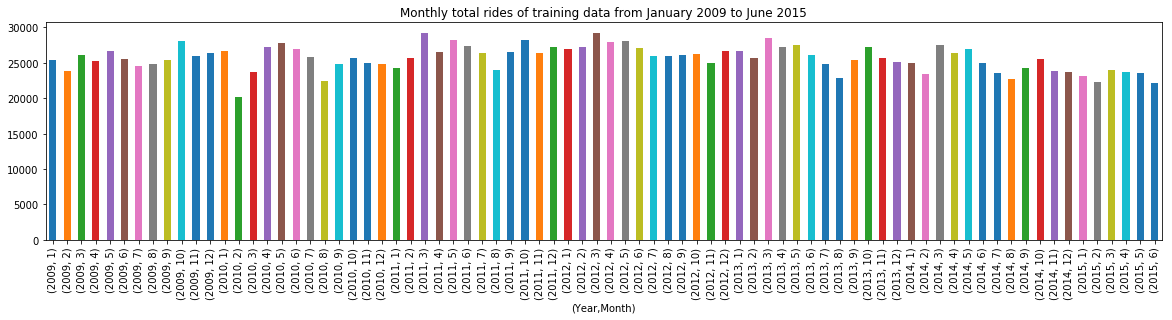

In [21]:
draw_barchart(fare_count_df, 'Monthly total rides of training data from January 2009 to June 2015')

In [22]:
test_group_df = test_df.pickup_datetime.groupby([test_df.pickup_datetime.dt.year,
                                                 test_df.pickup_datetime.dt.month]).count()

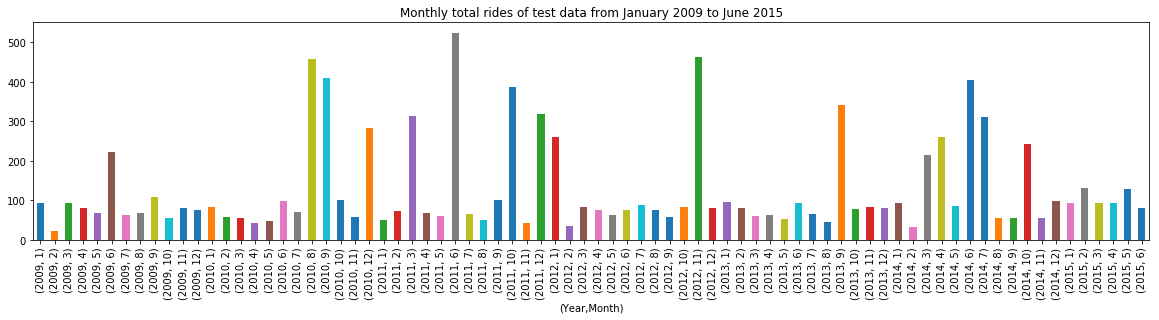

In [23]:
draw_barchart(test_group_df, 'Monthly total rides of test data from January 2009 to June 2015')

## Monthly mean fare

In [24]:
fare_mean_df.describe()

count    78.000000
mean     11.357738
std       1.293463
min       9.599622
25%      10.238145
50%      10.677635
75%      12.672094
max      13.555872
Name: fare_amount, dtype: float64

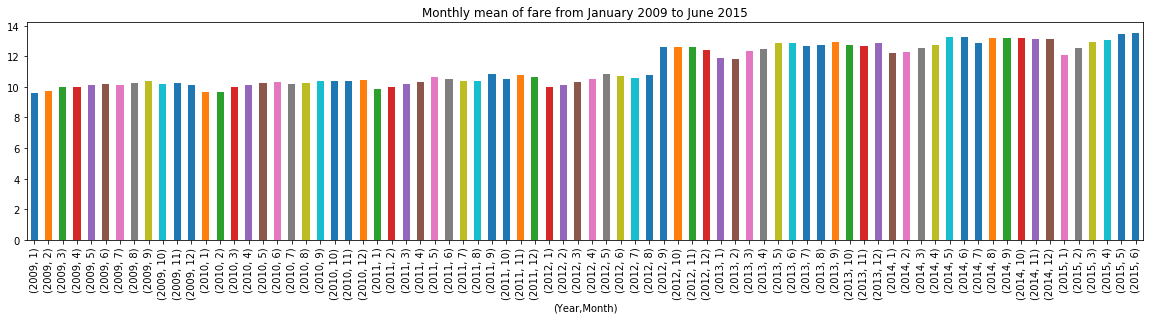

In [25]:
draw_barchart(fare_mean_df,'Monthly mean of fare from January 2009 to June 2015')

## Monthly median fare

In [26]:
fare_median_df.describe()

count    78.000000
mean      8.478205
std       0.847862
min       7.300000
25%       7.700000
50%       8.100000
75%       9.500000
max      10.000000
Name: fare_amount, dtype: float64

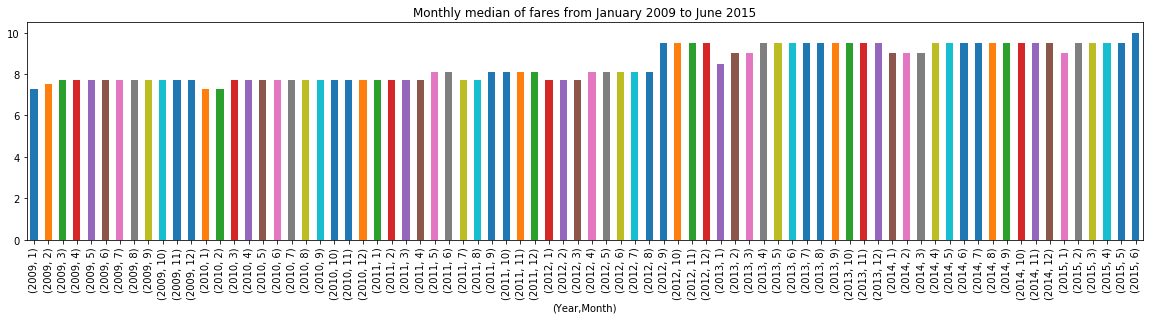

In [27]:
draw_barchart(fare_median_df,'Monthly median of fares from January 2009 to June 2015')

## Monthly minimum fare

In [28]:
fare_min_df.describe()

count    78.000000
mean      0.323077
std       9.612828
min     -76.000000
25%       2.500000
50%       2.500000
75%       2.500000
max       2.500000
Name: fare_amount, dtype: float64

In [29]:
print(f"Number of rides below $0.00: \t\t{len(train_df.fare_amount[train_df.fare_amount<0])}")
print(f"Number of rides at $0.00: \t\t{len(train_df.fare_amount[train_df.fare_amount==0])}")
print(f"Number of rides between $0.01 & $2.49:  {len(train_df.fare_amount[train_df.fare_amount.between(0,2.50,inclusive=False)])}")
print()
print(f"Number of rides below $2.50(all above): {len(train_df.fare_amount[train_df.fare_amount<2.5])}")
print()
print(f"Number of rides at $2.50: \t\t{len(train_df.fare_amount[train_df.fare_amount==2.5])}")
print(f"Number of rides of more than $2.50: \t{len(train_df.fare_amount[train_df.fare_amount>2.5])}")

Number of rides below $0.00: 		81
Number of rides at $0.00: 		58
Number of rides between $0.01 & $2.49:  35

Number of rides below $2.50(all above): 174

Number of rides at $2.50: 		8356
Number of rides of more than $2.50: 	1991470


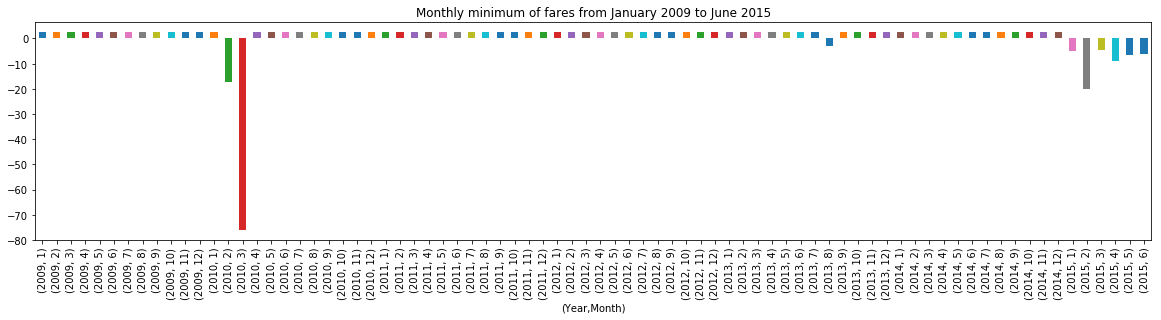

In [30]:
draw_barchart(fare_min_df, 'Monthly minimum of fares from January 2009 to June 2015')

## Monthly maximum fare

In [31]:
fare_max_df.describe()

count     78.000000
mean     228.635620
std      105.576851
min      113.000000
25%      170.000000
50%      198.500000
75%      257.250000
max      900.000000
Name: fare_amount, dtype: float64

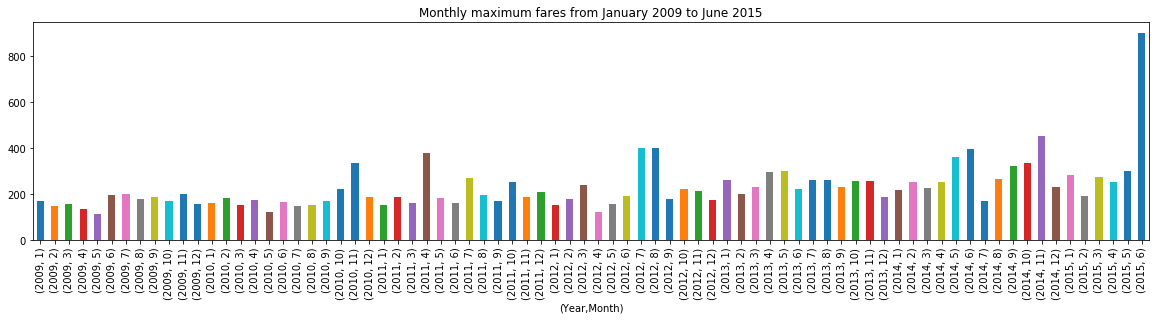

In [32]:
draw_barchart(fare_max_df, 'Monthly maximum fares from January 2009 to June 2015')

In [33]:
sorted_max_fare = fare_max_df.sort_values(ascending=False)

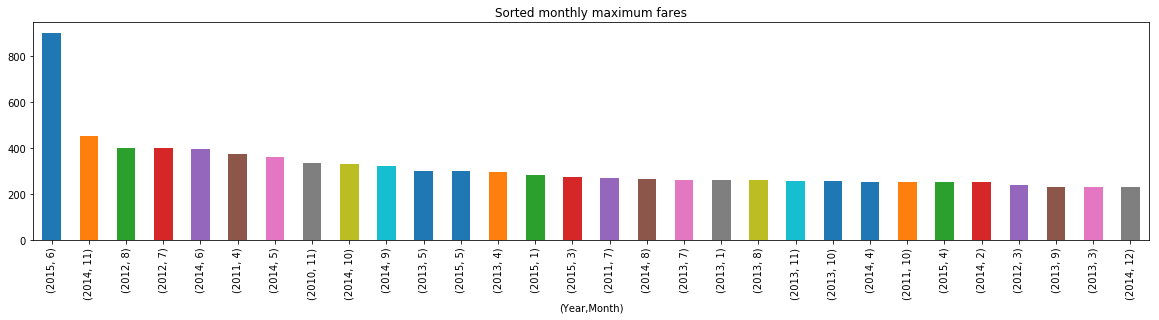

In [34]:
draw_barchart(sorted_max_fare.head(30), 'Sorted monthly maximum fares')

In [35]:
sorted_max_fare.head(30)

pickup_datetime  pickup_datetime
2015             6                  900.000000
2014             11                 450.000000
2012             8                  400.000000
                 7                  400.000000
2014             6                  395.000000
2011             4                  375.000000
2014             5                  358.209991
2010             11                 335.000000
2014             10                 331.410004
                 9                  321.660004
2013             5                  300.000000
2015             5                  300.000000
2013             4                  294.000000
2015             1                  283.000000
                 3                  271.829987
2011             7                  268.000000
2014             8                  262.329987
2013             7                  260.000000
                 1                  260.000000
                 8                  258.000000
                 11        